#Imports

<a href="https://colab.research.google.com/github/rjz46/Cornell-Conversational-Analysis-Toolkit/blob/master/datasets/reddit_coarse_discourse/Corpus_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.listdir()


['Corpus_conversion.ipynb',
 '.DS_Store',
 'corpus',
 'fetch_toxicity.ipynb',
 '.ipynb_checkpoints',
 'toxicity_dictionary.json',
 'readme.rst']

In [2]:
os.chdir('../..')

In [21]:
os.listdir()

['LICENSE.md',
 'convokit',
 '.DS_Store',
 'requirements.txt',
 'Makefile',
 'website',
 'datasets',
 'tests',
 'README.md',
 'setup.py',
 '.gitignore',
 'CONTRIBUTING.md',
 'examples',
 'doc',
 '.git']

In [7]:
import convokit

In [34]:
os.chdir("reddit_coarse_discourse-corpus")
os.listdir()

['coarse_discourse_dump_reddit_with_votes.json',
 'Corpus_conversion.ipynb',
 '.DS_Store',
 'corpus',
 'fetch_toxicity.ipynb',
 '.ipynb_checkpoints',
 'toxicity_dictionary.json',
 'readme.rst']

In [35]:
from IPython.display import display as disp
from zipfile import ZipFile

import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

sns.set_style('white')

#Users: initialization

In [36]:
os.listdir()

#@title Load json and make dict called "all_users" 
user_names = set()
DELETED_USER_NAME = '[deleted]'

with open('coarse_discourse_dump_reddit_with_votes.json', 'r') as f:
    for line in f:
        json_obj = json.loads(line)
        for post in json_obj['posts']:
            if 'author' in post:
                user_names.add(post['author'])
            else:
                # I spot checked a post and comment, and it seems that a missing 'author' means it was deleted (post: t3_29mjj7, comment: t1_crzi5yt in reply to t3_391dim)
                user_names.add(DELETED_USER_NAME)

all_users = {user_name: convokit.Speaker(name=user_name) for user_name in user_names}

print("Created {} users".format(len(all_users)))


Created 63573 users


In [37]:
#@title Check results
print("\nSample users:")
disp(list(all_users.items())[:3])


Sample users:


[('Youshotahostage', Speaker([('name', 'Youshotahostage')])),
 ('StoneCypher', Speaker([('name', 'StoneCypher')])),
 ('biverboy', Speaker([('name', 'biverboy')]))]

#Utterances

In [69]:
#@title Make "utterance_corpus" dict
'''

id: index of the utterance
user: the user who author the utterance
root: index of the conversation root of the utterance
reply_to: index of the utterance to which this utterance replies to (None if the utterance is not a reply)
timestamp: time of the utterance
text: textual content of the utterance

meta: dictionary of utterance metadata
    post_depth, 
    majority type
    ann_types
    majority_linkann_links
    ups
    
'''
user_names = set()
DELETED_USER_NAME = '[deleted]'

with open('coarse_discourse_dump_reddit_with_votes.json', 'r') as f:
  for line in f:
    json_obj = json.loads(line)
    for post in json_obj['posts']:
      if 'author' in post:
        user_names.add(post['author'])
      else:
        # I spot checked a post and comment, and it seems that a missing 'author' means it was deleted (post: t3_29mjj7, comment: t1_crzi5yt in reply to t3_391dim)
        user_names.add(DELETED_USER_NAME)

all_users = {user_name: convokit.Speaker(name=user_name) for user_name in user_names}

utterance_corpus = {}
      
with open('coarse_discourse_dump_reddit_with_votes.json', 'r') as f:
    for line in f:
      json_obj = json.loads(line)

      root = json_obj['posts'][0]['id']

      for post in json_obj['posts']:
        
        idx = post['id'] 
        text = post['body'] if 'body' in post else ""
        user, post_depth, in_reply_to = None, None, None
        
        if 'author' in post:
          user = post['author']
        else:
          user = DELETED_USER_NAME

        if 'is_first_post' in post:
          in_reply_to = None
          post_depth = 0
        else:
          in_reply_to = post['in_reply_to']
          post_depth = post['post_depth']

        annotations = post['annotations']  
  
        metadata = {
          'post_depth': post_depth,
          'majority_type': post['majority_type'] if 'majority_type' in post else None,
          'majority_link': post['majority_link'] if 'majority_link' in post else None,
          'annotation-types': [annotation['main_type'] for annotation in annotations],
          'annotation-links': [annotation['link_to_post'] if 'link_to_post' in annotation else None for annotation in annotations],
          'ups': post['ups'] if 'ups' in post else None

        }

        utterance_corpus[idx] = convokit.Utterance(idx, all_users[user], root, in_reply_to, None, text, meta=metadata)
      
    

In [70]:
print(len(user_names))
print(len(utterance_corpus))
disp(list(utterance_corpus.items())[:10])

63573
115827


[('t3_1bx6qw',
  Utterance({'id': 't3_1bx6qw', 'user': Speaker([('name', 'DTX120')]), 'root': 't3_1bx6qw', 'reply_to': None, 'timestamp': None, 'text': "4/7/13  \n\n7/27/12  \n\nhttp://www.imdb.com/title/tt0073440/reference\n\nIt was only a few minutes into Robert Altman's homespun epic *Nashville* that I got the feeling I was watching a great movie. By the end it could not be denied. Now I'm sure it helps that I'm a musician, since this created an immediate connection to the subject matter. I spent a portion of the movie with my Telecaster in my lap trying to play along with the characters who all seem to be really playing and singing these songs. However I also am *not* a fan of country western, so that could have easily been a turn off.  \n\nTo begin describing the action in the film is daunting. I can't even process a lot of what I saw. This movie is extremely dense, and the first 30 minutes or so are spent just trying to figure out who people are. Their relationships to one anothe

#Conversation

In [71]:
#@title Make "conversation_corpus" dict

conversation_corpus = {}
with open('coarse_discourse_dump_reddit_with_votes.json', 'r') as f:
  for line in f:
    json_obj = json.loads(line)
    
    posts = json_obj["posts"]
    first = posts[0]
    
    #print(first)
    
    if(first.get('author')!=None):
      owner = first['author']
    else:
      owner = '[deleted]'
    
    convo_id = first['id'][:]
    
    comments = []
    
    for comment in posts[:]:
      comments.append(comment['id'][:])
    
    meta_data = {
        "subreddit": json_obj['subreddit'], 
        "url": json_obj['url'],
        "title": json_obj['title']}
    
    conversation_corpus[convo_id] = convokit.Conversation(owner, convo_id, comments, meta_data)
    

In [99]:
subreddit_counter = Counter()

for convoutt in conversation_corpus: 
    subrd = conversation_corpus[convoutt].meta["subreddit"]
    subreddit_counter.update({subrd:1})
    
print(subreddit_counter.most_common(25))

[('askreddit', 425), ('leagueoflegends', 244), ('buildapc', 168), ('explainlikeimfive', 96), ('trees', 90), ('pcmasterrace', 86), ('gaming', 82), ('techsupport', 76), ('electronic_cigarette', 68), ('relationships', 54), ('tipofmytongue', 54), ('hearthstone', 53), ('atheism', 49), ('jailbreak', 49), ('summonerschool', 44), ('personalfinance', 42), ('reddit.com', 41), ('whowouldwin', 41), ('destinythegame', 38), ('movies', 38), ('pokemon', 38), ('starcraft', 38), ('malefashionadvice', 37), ('askscience', 35), ('loseit', 35)]


# Users: add utterances

In [73]:
#@title Test that adding utterances to users also updates user object attached to utterances

test_users = {user_name: convokit.Speaker(name=user_name) for user_name in ['user1', 'user2', 'user3']}

test_utterances = {
    'id1.1': convokit.Utterance('id1.1', test_users['user1'], None, None, None, 'some_text'),
    'id1.2': convokit.Utterance('id1.2', test_users['user1'], None, None, None, 'some_text'),
    'id2.1': convokit.Utterance('id2.1', test_users['user2'], None, None, None, 'some_text'),
}

test_convos = {
    'id1.1': convokit.Conversation(owner=None, id="id1.1", utterances=['id1.1', 'id2.1']),
    'id1.2': convokit.Conversation(owner=None, id="id1.2", utterances=['id1.2'])
    
}


for utt in test_utterances.values():
  utt.user.utterances[utt.id] = utt
  
for i, convo in enumerate(test_convos.values()):
  top_post = test_utterances[convo.id]
  top_post.user.conversations[convo.id] = convo

print("All test users, with associated utterance keys:")
for uid, user in test_users.items():
  print("\tUser ID: {} \tUtterance keys: {}".format(uid, list(user.utterances.keys())))
  
print()

print("All test users, with associated convo keys:")
for uid, user in test_users.items():
  print("\tUser ID: {} \tConvo keys: {}".format(uid, list(user.conversations.keys())))
  
print()

print("All test utterances, with associated user, and user's associated utterance keys:")
for utt_id, utt in test_utterances.items():
  print("\tUtt. ID: {} \tUser ID: {} \tUser's utt. keys: {}".format(utt_id, utt.user.name, list(utt.user.utterances.keys())))

All test users, with associated utterance keys:
	User ID: user1 	Utterance keys: ['id1.1', 'id1.2']
	User ID: user2 	Utterance keys: ['id2.1']
	User ID: user3 	Utterance keys: []

All test users, with associated convo keys:
	User ID: user1 	Convo keys: ['id1.1', 'id1.2']
	User ID: user2 	Convo keys: []
	User ID: user3 	Convo keys: []

All test utterances, with associated user, and user's associated utterance keys:
	Utt. ID: id1.1 	User ID: user1 	User's utt. keys: ['id1.1', 'id1.2']
	Utt. ID: id1.2 	User ID: user1 	User's utt. keys: ['id1.1', 'id1.2']
	Utt. ID: id2.1 	User ID: user2 	User's utt. keys: ['id2.1']


In [74]:
#@title Add utterances to all_users

for i, utt in enumerate(utterance_corpus.values()):
  utt.user.utterances[utt.id] = utt
  
print("Added {} utterances to all_users".format(i+1))

Added 115827 utterances to all_users


In [75]:
#@title Add convos to all_users
for i, convo in enumerate(conversation_corpus.values()):
  top_post = utterance_corpus[convo.id]
  top_post.user.conversations[convo.id] = convo
  
print("Added {} convos to all_users".format(i+1))

Added 9483 convos to all_users


#Corpus

In [76]:
#@title Create corpus and add conversation metadata
utterance_list = [utterance for k,utterance in utterance_corpus.items()]
reddit_corpus = convokit.Corpus(utterances=utterance_list, version=1)

for convo_id in reddit_corpus.get_conversation_ids():
  reddit_corpus.get_conversation(convo_id).meta = conversation_corpus[convo_id].meta

convo_ids = reddit_corpus.get_conversation_ids()
for i, convo_idx in enumerate(convo_ids[0:5]):
    print("sample conversation {}:".format(convo_idx))
    convo = reddit_corpus.get_conversation(convo_idx)
    user_id = convo.get_utterance(convo.id).user.name
    print("Meta: ", convo.meta)


sample conversation t3_1bx6qw:
Meta:  {'subreddit': '100movies365days', 'url': 'https://www.reddit.com/r/100movies365days/comments/1bx6qw/dtx120_87_nashville/', 'title': 'DTX120: #87 - Nashville'}
sample conversation t3_omv7p:
Meta:  {'subreddit': '100sets', 'url': 'https://www.reddit.com/r/100sets/comments/omv7p/male_23_years_old_going_for_100_sets/', 'title': 'Male, 23 years old. Going for 100 sets!'}
sample conversation t3_259tbh:
Meta:  {'subreddit': '1200isplenty', 'url': 'https://www.reddit.com/r/1200isplenty/comments/259tbh/122cal_black_currant_cheesecake/', 'title': '122cal black currant cheesecake!'}
sample conversation t3_16h61h:
Meta:  {'subreddit': '1911', 'url': 'https://www.reddit.com/r/1911/comments/16h61h/need_help_finding_a_springfield/', 'title': 'Need help finding a Springfield!'}
sample conversation t3_35igzp:
Meta:  {'subreddit': '1911', 'url': 'https://www.reddit.com/r/1911/comments/35igzp/help_with_a_possible_trade/', 'title': 'Help with a possible trade?'}


In [77]:
# @title Save to file and zip
reddit_corpus.dump("reddit_coarse_discourse", base_path = "")

with ZipFile("reddit_coarse_discourse.zip", 'w') as zip_f:
  for fname in os.listdir("reddit_coarse_discourse"):
    zip_f.write("reddit_coarse_discourse/"+fname)

In [78]:
#@title Show stats

print(len(reddit_corpus.get_utterance_ids()))
print(len(reddit_corpus.get_conversation_ids()))
print(len(reddit_corpus.get_usernames()))
reddit_corpus.print_summary_stats()

115827
9483
63573
Number of Users: 63573
Number of Utterances: 115827
Number of Conversations: 9483


# Part D: Stats and politeness transform

##Discourse type stats

In [79]:
type_corpus = {}
type_list = []

for x in utterance_corpus:
  #type_corpus[x] = utterance_corpus[x].meta["majority_type"]
  if(utterance_corpus[x].meta["majority_type"]==None):
    type_list.append("no consensus")
  else:
    type_list.append(utterance_corpus[x].meta["majority_type"])
  
#print(type_list)

from collections import Counter

ctrdata = Counter(type_list)

announcement 2002 1.73%
elaboration 19258 16.63%
humor 2417 2.09%
appreciation 8710 7.52%
question 17594 15.19%
answer 41162 35.54%
no consensus 12277 10.6%
agreement 5040 4.35%
negativereaction 1896 1.64%
disagreement 3422 2.95%
other 2049 1.77%


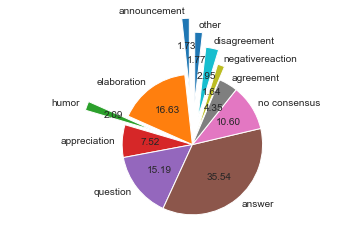

In [80]:
#https://pythontic.com/visualization/charts/piechart
import matplotlib.pyplot as plotter

for x in ctrdata:
  y = ctrdata[x]
  percenty = y / 115827 * 100;
  print(x + " " + str(y) + " " + str(round(percenty,2)) + "%")

uttlabels = ctrdata.keys()
data = ctrdata.values()

explode = (0.8, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.4, 0.6)

figureObject, axesObject = plotter.subplots()

# Draw the pie chart

axesObject.pie(data,explode=explode,

        labels=uttlabels,

        autopct='%1.2f',

        startangle=90)

 

# Aspect ratio - equal means pie is a circle

axesObject.axis('equal')

 

plotter.show()

# Politeness transform - don't need to run this

In [81]:
#@title Prep corpus by running parser
import convokit
parser = convokit.Parser()
reddit_corpus = parser.transform(reddit_corpus)

KeyboardInterrupt: 

In [63]:
# @title Save again
reddit_corpus.dump("reddit_coarse_discourse_with_parsed", base_path = "")

with ZipFile("reddit_coarse_discourse_with_parsed.zip", 'w') as zip_f:
  for fname in os.listdir("reddit_coarse_discourse_with_parsed"):
    zip_f.write("reddit_coarse_discourse_with_parsed/"+fname)

In [64]:
#@title Get politeness strategies

ps = convokit.PolitenessStrategies()
reddit_corpus = ps.transform(reddit_corpus)

KeyError: 'parsed'

In [ ]:
# @title Save one more time
reddit_corpus.dump("reddit_coarse_discourse_with_parsed_and_politeness", base_path = "")

with ZipFile("reddit_coarse_discourse_with_parsed_and_politeness.zip", 'w') as zip_f:
  for fname in os.listdir("reddit_coarse_discourse_with_parsed_and_politeness"):
    zip_f.write("reddit_coarse_discourse_with_parsed_and_politeness/"+fname)

# Run from here on

In [82]:
#@title Load from file
reddit_corpus = convokit.Corpus(filename="reddit_coarse_discourse_with_parsed_and_politeness")

In [83]:
utterance_ids = reddit_corpus.get_utterance_ids()
rows = []
for uid in utterance_ids:
    meta = reddit_corpus.get_utterance(uid).meta["politeness_strategies"]
    meta = {k.split('==')[1]: v for k, v in meta.items()}
    majority_type = reddit_corpus.get_utterance(uid).meta['majority_type']
    meta['discourse_cat'] = majority_type if majority_type else "NO CONSENSUS"
    rows.append(meta)
politeness_strategies = pd.DataFrame(rows, index=utterance_ids)
politeness_strategies.head(10)

,1st_person,1st_person_pl.,1st_person_start,2nd_person,2nd_person_start,Apologizing,Deference,Direct_question,Direct_start,Factuality,...,HASNEGATIVE,HASPOSITIVE,Hedges,INDICATIVE,Indirect_(btw),Indirect_(greeting),Please,Please_start,SUBJUNCTIVE,discourse_cat
t3_1bx6qw,1,1,1,0,0,0,0,0,1,1,...,1,1,1,0,0,0,0,0,0,announcement
t1_c9b2nyd,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,elaboration
t1_c9b30i1,1,0,1,0,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,elaboration
t1_c9b6sj0,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,elaboration
t3_omv7p,1,0,1,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,announcement
t1_c3igqif,1,1,1,1,0,0,0,0,1,0,...,1,1,1,0,0,0,0,0,0,elaboration
t1_c3imrkb,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,humor
t1_c3ij8z0,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,appreciation
t1_c3inx9t,1,0,0,0,0,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,appreciation
t1_c3k2lc1,1,1,0,0,0,1,0,1,1,0,...,1,1,0,0,0,0,0,0,0,elaboration


In [84]:
#@title Table of politeness strategies by discourse category
politeness_counts = politeness_strategies.groupby('discourse_cat').sum()
disp(politeness_counts)


,1st_person,1st_person_pl.,1st_person_start,2nd_person,2nd_person_start,Apologizing,Deference,Direct_question,Direct_start,Factuality,...,HASHEDGE,HASNEGATIVE,HASPOSITIVE,Hedges,INDICATIVE,Indirect_(btw),Indirect_(greeting),Please,Please_start,SUBJUNCTIVE
discourse_cat,,,,,,,,,,,,,,,,,,,,,
NO CONSENSUS,4294,1159,4109,3350,833,217,283,632,1753,1229,...,3568,5468,6379,1721,42,5,90,94,61,49
agreement,2258,466,2155,1195,270,26,86,145,807,585,...,1751,2280,3119,920,6,1,13,13,6,5
announcement,865,430,738,647,159,85,30,148,507,315,...,804,946,1107,444,12,1,73,76,37,9
answer,16409,3649,15508,14933,4267,467,595,1679,7381,5420,...,16235,19844,24772,6801,114,11,181,173,104,121
appreciation,3035,429,2892,1938,440,66,949,204,805,752,...,1761,2187,6125,870,18,0,78,28,19,25
disagreement,1153,447,1185,1241,382,53,19,195,694,563,...,1454,2060,2134,723,7,3,6,9,11,11
elaboration,8185,2034,7547,5861,1407,293,313,655,3645,2583,...,7529,9726,11407,3400,30,9,92,97,63,40
humor,452,111,381,497,138,22,12,101,156,58,...,288,740,685,118,5,0,22,11,4,6
negativereaction,438,135,394,556,201,31,42,142,201,148,...,393,1175,750,145,5,1,9,8,16,3


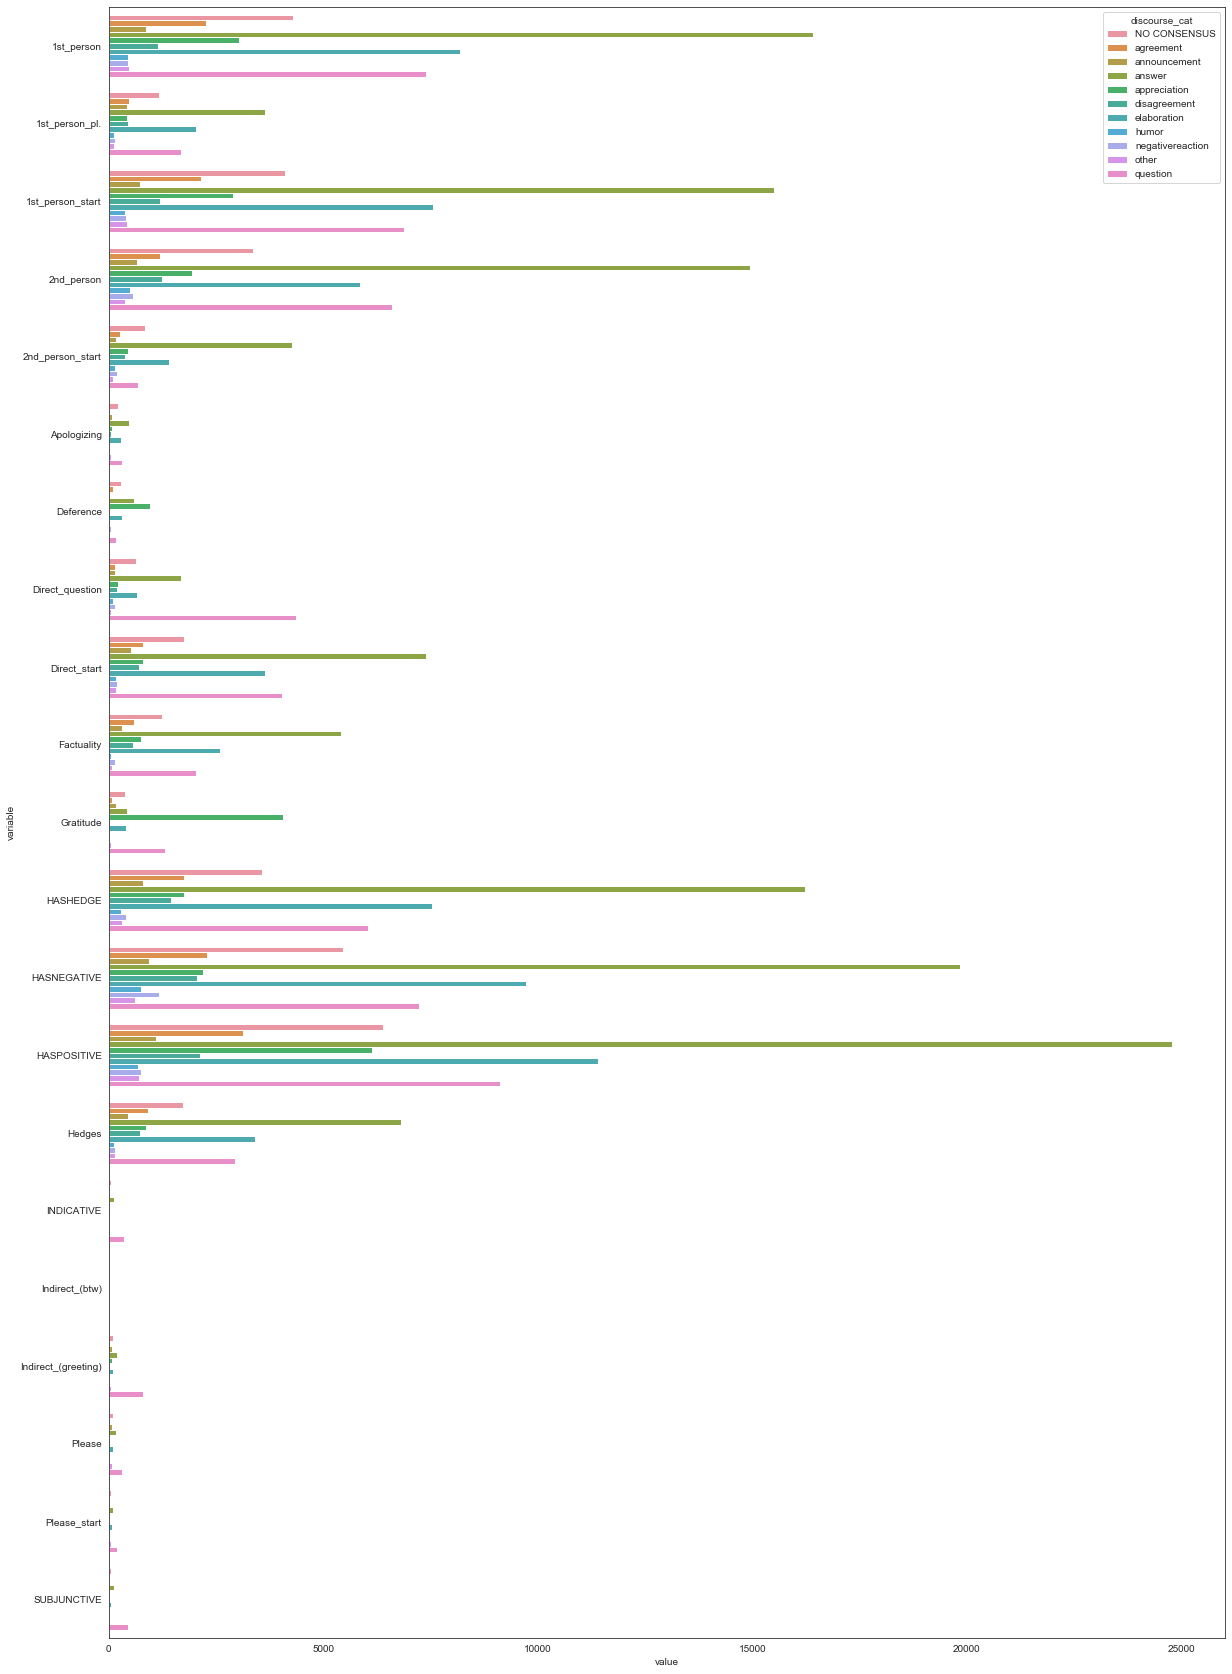

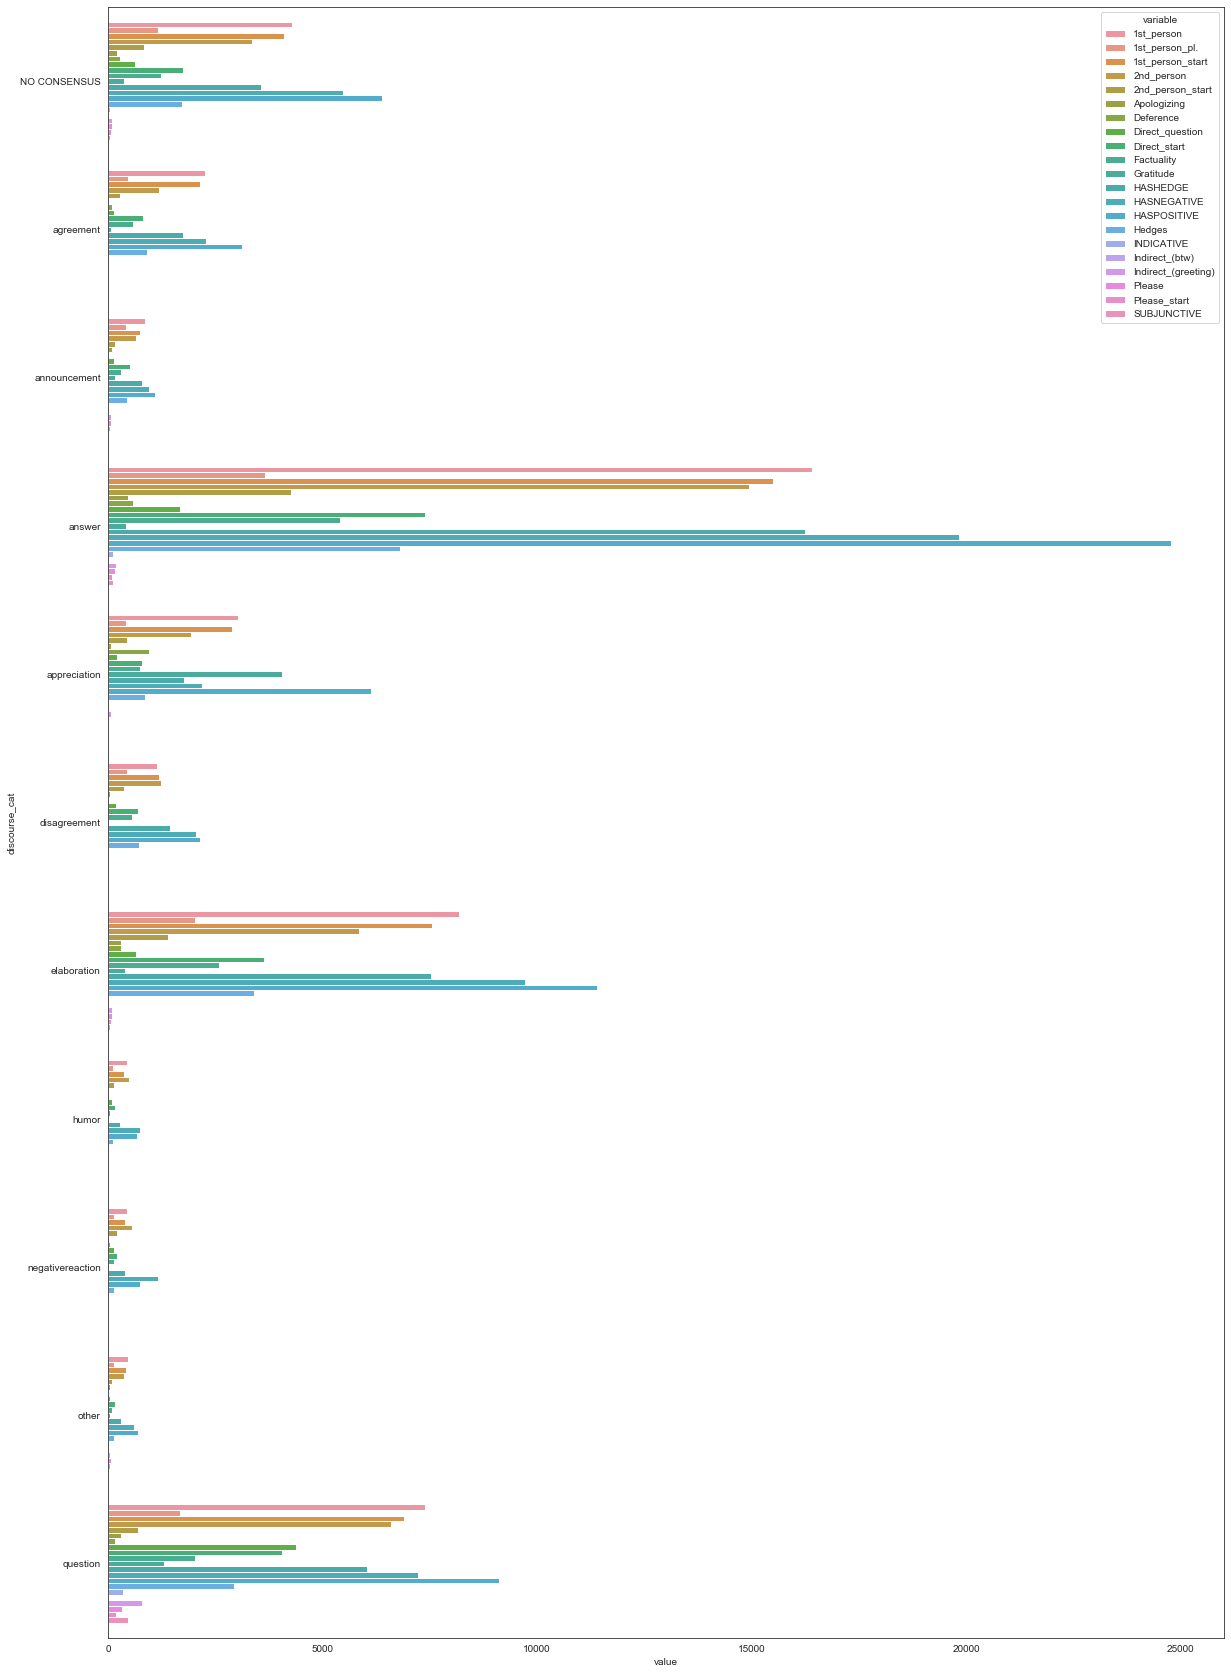

In [85]:
#@title Bar plots by politeness strategy and discourse category
politeness_counts_melted = politeness_counts.reset_index().melt(id_vars="discourse_cat")

fig, ax = plt.subplots(1,1, figsize=(20,30))
sns.barplot(
    data=politeness_counts_melted,
    y="variable", # politeness cat
    x='value',
    hue='discourse_cat',
    ax=ax
    )

fig, ax = plt.subplots(1,1, figsize=(20,30))
sns.barplot(
    data=politeness_counts_melted,
    y="discourse_cat", # politeness cat
    x='value',
    hue='variable',
    ax=ax
    )
